<a href="https://colab.research.google.com/github/mohamed-stifi/-Image-Classification-with-PyTorch-and-CIFAR-10-dataset/blob/main/_image_classification_with_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import transforms
from torchvision.utils import make_grid
%matplotlib inline
torch.manual_seed(43)

## Download and preprocess the CIFAR-10 dataset



In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
batch_size = 4
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = trainset.classes

Files already downloaded and verified
Files already downloaded and verified


With this for loop, we can get the number of images per class in train and test data set.

In [ ]:
train_class_count = {}
for _, index in trainset:
    label = classes[index]
    if label not in train_class_count:
        train_class_count[label] = 0
    train_class_count[label] += 1
test_class_count = {}
for _, index in testset:
    label = classes[index]
    if label not in test_class_count:
        test_class_count[label] = 0
    test_class_count[label] += 1
train_class_count,test_class_count

({'frog': 5000,
  'truck': 5000,
  'deer': 5000,
  'automobile': 5000,
  'bird': 5000,
  'horse': 5000,
  'ship': 5000,
  'cat': 5000,
  'dog': 5000,
  'airplane': 5000},
 {'cat': 1000,
  'ship': 1000,
  'airplane': 1000,
  'frog': 1000,
  'automobile': 1000,
  'truck': 1000,
  'dog': 1000,
  'horse': 1000,
  'deer': 1000,
  'bird': 1000})

Here, we can visualize a batch of data using the make_grid helper function from Torchvision.

images.shape: torch.Size([4, 3, 32, 32])
cat   horse ship  dog  


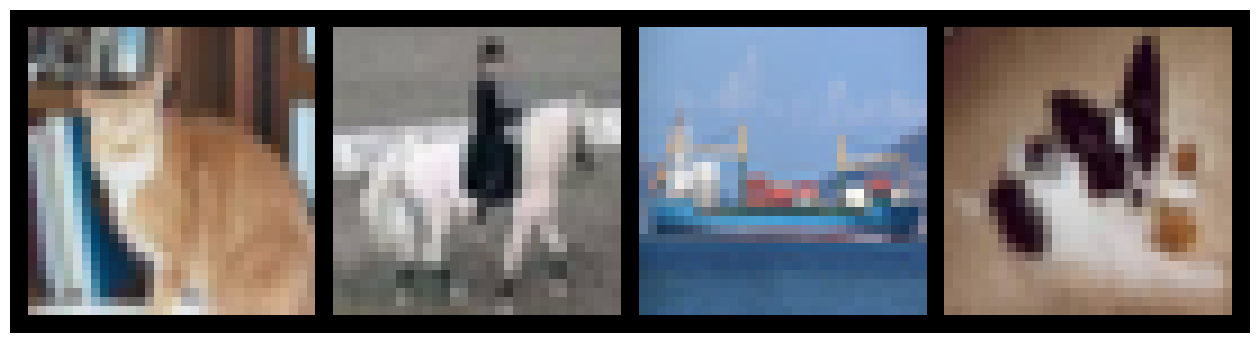

In [ ]:
for images, labels in trainloader:
    print('images.shape:', images.shape)
    print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
    images = images/2 + 0.5   # unnormalize
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    plt.xlabel(labels)
    break

images.shape: torch.Size([4, 3, 32, 32])
cat   ship  ship  airplane


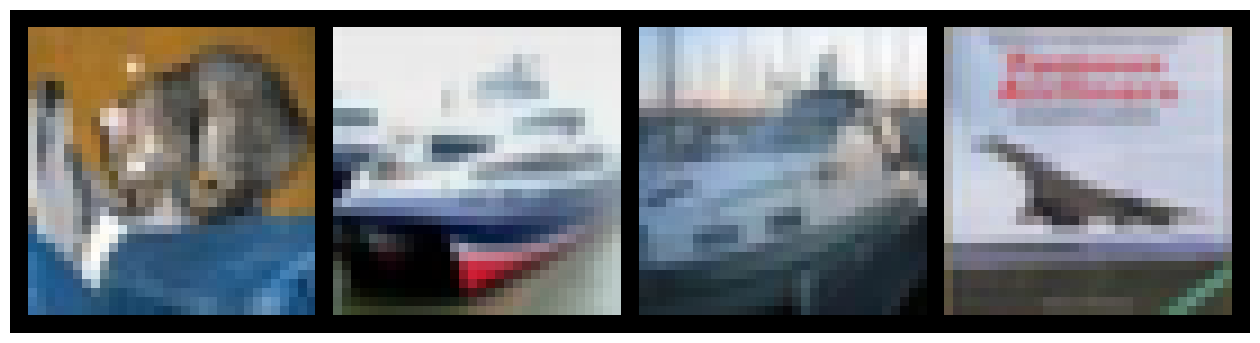

In [ ]:
for images, labels in testloader:
    print('images.shape:', images.shape)
    print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
    images = images/2 + 0.5   # unnormalize
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    plt.xlabel(labels)
    break

##Build a CNN model for image classification

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


##Train model on the training dataset

In [ ]:
cnn = CNN()
num_epook = 5
Loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.01)

In [ ]:
history = []
for epook  in  range(num_epook):
    for i, (imgs, labels) in enumerate(trainloader):
      if i%10 == 0 :
        optimizer.zero_grad()
        outs = cnn(imgs)
        loss = Loss(outs, labels)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
          print(f"epook [{epook}/{num_epook}] | i = {i} | loss = {loss.item()}")
        history.append([loss.item(), accuracy(outs, labels)])


In [ ]:
PATH = './cnn_model.pth'
torch.save(cnn.state_dict(), PATH)

##Evaluate model's performance on the test dataset

In [ ]:
cnn_load = CNN()
cnn_load.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

In [ ]:
outputs = cnn_load(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))
print('True: ', ' '.join(f'{classes[labels[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  ship 
True:  cat   ship  ship  airplane


In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:

        outputs = cnn_load(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 39 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}


with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)

        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: airplane is 0.0 %
Accuracy for class: automobile is 0.0 %
Accuracy for class: bird  is 0.0 %
Accuracy for class: cat   is 0.0 %
Accuracy for class: deer  is 9.5 %
Accuracy for class: dog   is 0.0 %
Accuracy for class: frog  is 0.0 %
Accuracy for class: horse is 0.0 %
Accuracy for class: ship  is 90.5 %
Accuracy for class: truck is 0.0 %


##Visualize the train of model

In [ ]:
def plot_losses(history):

    plt.plot(history, '-x')
    #plt.xlabel('epoch')
    plt.ylabel('loss')
    #plt.title('Loss vs. No. of epochs');

In [ ]:
def plot_accuracies(history):

    plt.plot(history, '-x')

    plt.ylabel('accuracy')


In [ ]:
history = np.array(history)

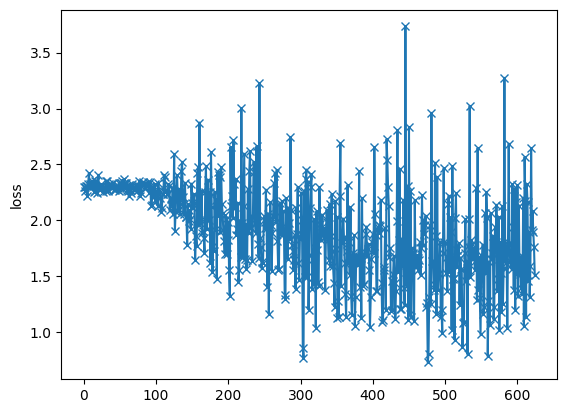

In [ ]:
plot_losses(history[::10,0])

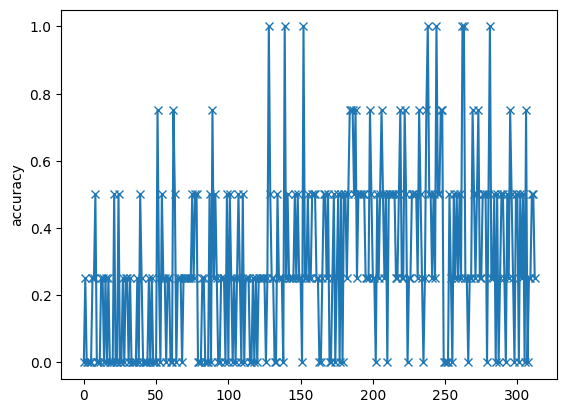

In [ ]:
plot_accuracies(history[::20,1])